<a href="https://colab.research.google.com/github/waelrash1/predictive_analytics_DT302/blob/main/Lab_Ridge_Regression_and_the_Lasso_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularization and Shrinkage: Ridge, Lasso and Elastic Net Regression

This lab on Ridge Regression and the Lasso is a Python adaptation of p. 251-255 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Adapted by R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).

# 6.6: Ridge Regression and the Lasso

In [38]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

We will use the `sklearn` package in order to perform ridge regression and
the lasso. The main functions in this package that we care about are `Ridge()`, which can be used
to fit ridge regression models, and `Lasso()` which will fit lasso models. They also have cross-validated counterparts: `RidgeCV()` and `LassoCV()`. We'll use these a bit later.

Before proceeding, let's first ensure that the missing values have
been removed from the data, as described in the previous lab.

In [39]:
url='https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv'
df = pd.read_csv(url).dropna()

df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64(1), 

We will now perform ridge regression and the lasso in order to predict `Salary` on
the `Hitters` data. Let's set up our data:

In [40]:
y = np.log(df.Salary)

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    bool   
 17  Division_W   263 non-null    bool   
 18  NewLeague_N  263 non-null    bool   
dtypes: bool(3), f

In [41]:
X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,True,True,True
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,False,True,False
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,True,False,True
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,True,False,True
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,False,True,False


# 6.6.1 Ridge Regression
The `Ridge()` function has an alpha argument ($\lambda$, but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially
covering the full range of scenarios from the null model containing
only the intercept, to the least squares fit:

In [42]:
alphas = 10**np.linspace(10,-2,100) *0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

Associated with each alpha value is a vector of ridge regression coefficients, which we'll
store in a matrix `coefs`. In this case, it is a $19 \times 100$
matrix, with 19 rows (one for each predictor) and 100
columns (one for each value of alpha). Remember that we'll want to standardize the
variables so that they are on the same scale. To do this, we can use the
`normalize = True` parameter:

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
import numpy as np

ridge = Ridge()
coefs = []

for a in alphas:
    pipeline = Pipeline([
        ('data_scale', MinMaxScaler()),
        ('ridge', Ridge(alpha=a))
    ])
    pipeline.fit(X, y)
    coefs.append(pipeline.named_steps['ridge'].coef_)

np.shape(coefs)

(100, 19)

We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm,
when a large value of alpha is used, as compared to when a small value of alpha is
used. Let's plot and find out:

Text(0, 0.5, 'weights')

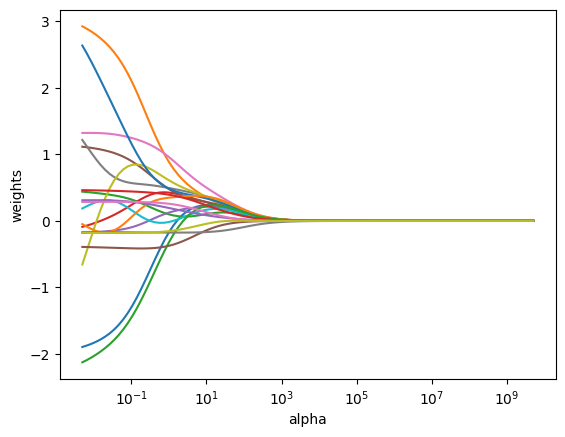

In [51]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression and the lasso:

In [52]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

Next we fit a ridge regression model on the training set, and evaluate
its MSE on the test set, using $\lambda = 4$:

In [66]:
ridge2 =  Pipeline([
        ('data_scale', MinMaxScaler()),
        ('ridge', Ridge(alpha=10))
    ])

ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data

pred2 = ridge2.predict(X_test)           # Use this model to predict the test data

print(pd.Series(ridge2.named_steps['ridge'].coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

AtBat          0.188597
Hits           0.220111
HmRun          0.098988
Runs           0.229620
RBI            0.214565
Walks          0.332945
Years          0.348136
CAtBat         0.274125
CHits          0.309117
CHmRun         0.146998
CRuns          0.258100
CRBI           0.240051
CWalks         0.203849
PutOuts        0.269658
Assists       -0.012552
Errors        -0.051703
League_N       0.113170
Division_W    -0.120210
NewLeague_N   -0.006299
dtype: float64
0.42341175207139387


The test MSE when alpha = 10 is 0.42341175207139387 . Now let's see what happens if we use a huge value of alpha, say $10^{10}$:

In [55]:
ridge3 = Pipeline([
        ('data_scale', MinMaxScaler()),
        ('ridge', Ridge(alpha=10**10))
    ])

ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge3.named_steps['ridge'].coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))          # Calculate the test MSE

AtBat          1.120422e-09
Hits           1.040511e-09
HmRun          9.929935e-10
Runs           1.145667e-09
RBI            1.270528e-09
Walks          1.262325e-09
Years          1.607144e-09
CAtBat         1.734246e-09
CHits          1.858845e-09
CHmRun         1.053049e-09
CRuns          1.599069e-09
CRBI           1.540182e-09
CWalks         1.264843e-09
PutOuts        8.830094e-10
Assists       -2.467048e-11
Errors        -3.813152e-11
League_N       4.424877e-11
Division_W    -4.454754e-10
NewLeague_N   -8.366075e-11
dtype: float64
0.784425588980893


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test
MSE than fitting a model with just an intercept. We now check whether
there is any benefit to performing ridge regression with alpha = 4 instead of
just performing least squares regression. Recall that least squares is simply
ridge regression with alpha = 0.

In [58]:

ridge3.set_params(ridge__alpha=0).fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge3.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge3.named_steps['ridge'].coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))           # Calculate the test MSE

AtBat         -1.027916
Hits           1.364098
HmRun         -0.051144
Runs           0.266629
RBI            0.326999
Walks          1.103796
Years          1.850686
CAtBat        -2.918875
CHits          3.462395
CHmRun         1.676298
CRuns          0.218662
CRBI          -1.653292
CWalks        -0.610820
PutOuts        0.618516
Assists        0.175604
Errors        -0.345489
League_N       0.351842
Division_W    -0.173522
NewLeague_N   -0.189075
dtype: float64
0.4156136841742947


It looks like we are indeed improving over regular least-squares!

Instead of arbitrarily choosing alpha $ = 4$, it would be better to
use cross-validation to choose the tuning parameter alpha. We can do this using
the cross-validated ridge regression function, `RidgeCV()`. By default, the function
performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the
argument `cv`.

In [63]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')

pipeline2 = Pipeline([
    ('data_scale', MinMaxScaler()),
    ('ridcv', ridgecv)
])
pipeline2.fit(X_train, y_train)

# Accessing the coefficients after fitting
pipeline2.named_steps['ridcv'].coef_

array([ 0.17531117,  0.27783291,  0.04718293,  0.27253086,  0.23506939,
        0.46985153,  0.49260159,  0.27324903,  0.33187711,  0.1349254 ,
        0.26737756,  0.24272814,  0.19255688,  0.38071697, -0.01723302,
       -0.11059261,  0.17499873, -0.14417028, -0.04764044])

In [61]:
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

Therefore, we see that the value of alpha that results in the smallest cross-validation
error is 0.57. What is the test MSE associated with this value of
alpha?

In [64]:
# After fitting the pipeline
best_alpha = pipeline2.named_steps['ridcv'].alpha_
print("Best alpha:", best_alpha)

Best alpha: 4.055654153948428


In [65]:
ridge4 = Ridge(alpha = best_alpha)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

0.4135061637931712

This represents a further improvement over the test MSE that we got using
alpha $ = 4$. Finally, we refit our ridge regression model on the full data set,
using the value of alpha chosen by cross-validation, and examine the coefficient
estimates.

In [67]:
ridge4.fit(X, y)
pd.Series(ridge4.coef_, index = X.columns)

,0
AtBat,-0.003064
Hits,0.013272
HmRun,0.011766
Runs,-0.001457
RBI,-0.001614
Walks,0.010935
Years,0.056477
CAtBat,0.000137
CHits,-0.000512
CHmRun,-0.000180


As expected, none of the coefficients are exactly zero - ridge regression does not
perform variable selection!

# 6.6.2 The Lasso
We saw that ridge regression with a wise choice of alpha can outperform least
squares as well as the null model on the Hitters data set. We now ask
whether the lasso can yield either a more accurate or a more interpretable
model than ridge regression. In order to fit a lasso model, we'll
use the `Lasso()` function; however, this time we'll need to include the argument `max_iter = 10000`.
Other than that change, we proceed just as we did in fitting a ridge model:

Text(0, 0.5, 'weights')

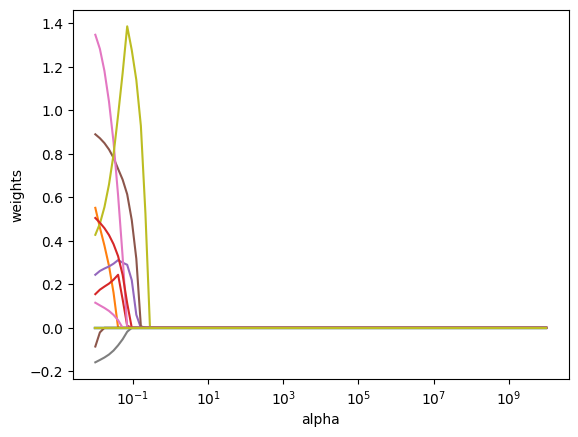

In [69]:
lasso = Lasso(max_iter = 10000)
coefs = []

pipelineLasso = Pipeline([
    ('data_scale', MinMaxScaler()),
    ('lasso', lasso)
])

for a in alphas:
    pipelineLasso.set_params(lasso__alpha=a).fit(X_train, y_train)
    coefs.append(pipelineLasso.named_steps['lasso'].coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning
parameter, some of the coefficients are exactly equal to zero. We now
perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [ ]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

104960.65853895503

In [71]:
# Define the LassoCV model with cross-validation
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000)

# Create a pipeline with MinMaxScaler and LassoCV
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('lassocv', lassocv)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Retrieve the best alpha from LassoCV
best_alpha = pipeline.named_steps['lassocv'].alpha_

coeff_lasso= pipeline.named_steps['lassocv'].coef_

# Create a final Lasso model using the best alpha
lasso = Lasso(alpha=best_alpha)
lasso_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('lasso', lasso)
])

# Fit the final Lasso model on the training data
lasso_pipeline.fit(X_train, y_train)

# Evaluate on the test set
mse = mean_squared_error(y_test, lasso_pipeline.predict(X_test))
print("Best alpha:", best_alpha)
print("Mean Squared Error on test set:", mse)

Best alpha: 0.011509670124403976
Mean Squared Error on test set: 0.42245174669571944


This is substantially lower than the test set MSE of the null model and of
least squares, and only a little worse than the test MSE of ridge regression with alpha
chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in
that the resulting coefficient estimates are sparse. Here we see that 13 of
the 19 coefficient estimates are exactly zero:

In [74]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(coeff_lasso, index=X.columns)

,0
AtBat,0.000000
Hits,0.286107
HmRun,0.000000
Runs,0.202918
RBI,0.281830
Walks,0.820127
Years,1.041918
CAtBat,0.000000
CHits,0.656953
CHmRun,0.000000


In [81]:

# Create a Series with feature names as index and coefficients as values
feature_importance = pd.Series(coeff_lasso, index=X_train.columns)

# Filter to show only non-zero coefficients
selected_features = feature_importance[feature_importance != 0]
unselected_features = feature_importance[feature_importance == 0]

# Print the selected features
print(" Selected features with non-zero coefficients:")
print(selected_features)
print("unSelected features with zero coefficients:")
print(unselected_features)



 Selected features with non-zero coefficients:
Hits          0.286107
Runs          0.202918
RBI           0.281830
Walks         0.820127
Years         1.041918
CHits         0.656953
PutOuts       0.426824
League_N      0.077682
Division_W   -0.122898
dtype: float64
unSelected features with zero coefficients:
AtBat          0.0
HmRun          0.0
CAtBat         0.0
CHmRun         0.0
CRuns          0.0
CRBI           0.0
CWalks         0.0
Assists       -0.0
Errors        -0.0
NewLeague_N    0.0
dtype: float64


# Elastic Net

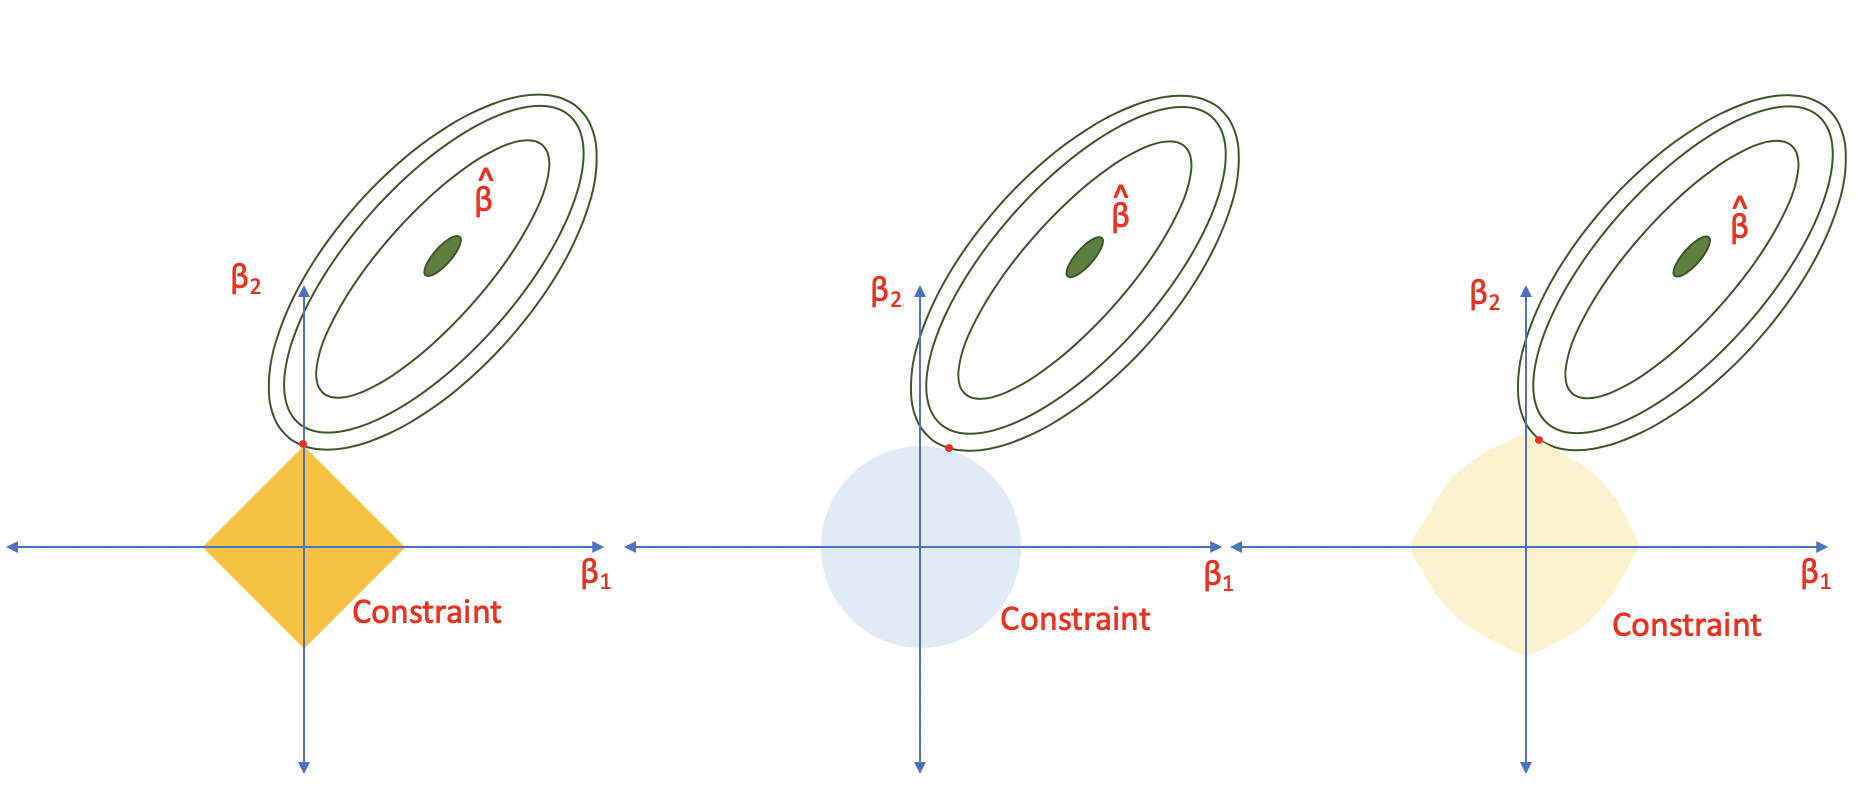

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [84]:

from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.linear_model import ElasticNet


# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
X, y = data[:, :-1], data[:, -1]



In [86]:
y

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [87]:

# Define the pipeline with MinMaxScaler and ElasticNet
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('elasticnet', ElasticNet(alpha=1.0, l1_ratio=0.5))
])

# Define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Evaluate model
scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# Force scores to be positive and summarize the performance
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 6.015 (0.705)


# Grid search hyperparameters for the elastic net

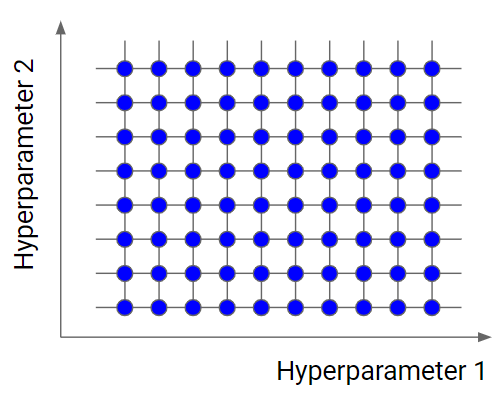

In [90]:
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


# Define the pipeline with MinMaxScaler and ElasticNet
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('elasticnet', ElasticNet())
])

# Define the cross-validation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# Define the parameter grid
grid = {
    'elasticnet__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0],
    'elasticnet__l1_ratio': arange(0, 1, 0.1)
}

# Define the grid search
search = GridSearchCV(pipeline, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# Perform the grid search
results = search.fit(X, y)

# Summarize the results
print('Best MAE: %.3f' % abs(results.best_score_))
print('Best Config: %s' % results.best_params_)


Best MAE: 3.344
Best Config: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.8}


In [96]:
# Retrieve the best alpha and l1_ratio
best_alpha = search.best_params_['elasticnet__alpha']
best_l1_ratio = search.best_params_['elasticnet__l1_ratio']

# Step 2: Define a new pipeline using the best parameters for evaluation
final_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('elasticnet', ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio))
])

# Evaluate the final model
scores = cross_val_score(final_pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 3.341 (0.539)


# Use automatically configured elastic net algorithm

In [102]:
# use automatically configured elastic net algorithm

# Define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define ratios and alphas for ElasticNetCV
ratios = arange(0.1, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1.0, 10.0, 100.0]

# Create a pipeline with Min-Max scaling and ElasticNetCV
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scaling the features
    ('model', ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1))  # Step 2: Model fitting
])

# Fit the model using the pipeline
pipeline.fit(X, y)

# Summarize chosen configuration
model = pipeline.named_steps['model']  # Access the fitted model from the pipeline
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)

alpha: 0.001000
l1_ratio_: 0.220000


In [103]:
model = ElasticNet(alpha=model.alpha_, l1_ratio=model.l1_ratio_)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 3.380 (0.525)


# Your turn!
Now it's time to test out these approaches (ridge regression and the lasso) and evaluation methods (validation set, cross validation) on other datasets. You may want to work with a team on this portion of the lab.
You may use any of the datasets included in ISLR, or choose one from the UCI machine learning repository. Download a dataset, and try to determine the optimal set of parameters to use to model it! You are free to use the same dataset you used in Lab 9, or you can choose a new one.

In [ ]:
# Your code here

To get credit for this lab, post your responses to the following questions:
 - Which dataset did you choose?
 - What was your response variable (i.e. what were you trying to model)?
 - Did you expect ridge regression to outperform the lasso, or vice versa?
 - Which predictors turned out to be important in the final model(s)?

